<div style="text-align: left;">
    <h1>Week 3 - Laboratory</h1>
    <h4>ECON441B</h3>
    <div style="padding: 20px 0;">
        <hr style="border: 0; height: 1px; background-image: linear-gradient(to right, rgba(0, 0, 0, 0), rgba(0, 0, 0, 0.75), rgba(0, 0, 0, 0));">
        <p><em>Mauricio Vargas-Estrada</em><br>
        Master in Quantitative Economics<br>
        University of California - Los Angeles</p>
        <hr style="border: 0; height: 1px; background-image: linear-gradient(to right, rgba(0, 0, 0, 0), rgba(0, 0, 0, 0.75), rgba(0, 0, 0, 0));">
    </div>
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pytrends.request import TrendReq

# Imputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

# Disable all warnings
import warnings
warnings.filterwarnings('ignore')

# 0.) Clean the Apple Data to get a quarterly series of EPS.

In [2]:
data = pd.read_csv('AAPL_quarterly_financials.csv')

In [3]:
# Transposing the data and setting the first row as the column names
data = data.T
data.columns = ['dates'] +  data.iloc[0,:]
data = data.drop(data.index[0:2,])

In [4]:
# Converting data.index to datetime
data.index = pd.to_datetime(data.index)

In [5]:
# Ordering the data from oldest to newest
data = data.sort_index()

In [6]:
# Converting to numeric, but the numbers are strings with commas.
data = data.apply(lambda x: x.str.replace(',',''))
data = data.apply(pd.to_numeric)

In [7]:
# Using an nearest neighbor imputer to fill in missing values. 
# The 5 nearest neighbors are used to fill in the missing values.
imputer = KNNImputer(n_neighbors=5)
data = pd.DataFrame(
    imputer.fit_transform(data),
    columns=data.columns,
    index=data.index
)

In [8]:
# Getting a DataFrame containing the columns that contain the word 'EPS'
eps_name = data.columns.str.contains('EPS')
eps = data.iloc[:,eps_name]

<Axes: >

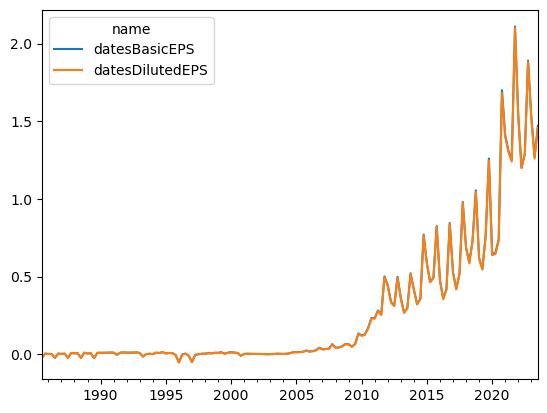

In [9]:
eps.plot()

# 1.) Come up with 6 search terms you think could nowcast earnings. (Different than the ones I used) Add in 3 terms that that you think will not Nowcast earnings. Pull in the gtrends data. Clean it to have a quarterly average.

In [10]:
# Create pytrends object
pytrends = TrendReq(hl='en-US', tz=360)

# Set up the keywords and the timeframe
keywords = [
    'Apple',
    'Macintosh',
    'Apple Stocks',
    'Apple Financial',
    'Apple Earnings',
    'NASDAQ', 
    'SP500', 
    'GDP',
    'Technology',
    'Linear Regression',
    'Bayes Theorem',
    'UCLA'
]  # Add your keywords here
start_date = '2004-01-01'
end_date = '2024-01-01'

# Create an empty DataFrame to store the results
df = pd.DataFrame()

# Iterate through keywords and fetch data
for keyword in keywords:
    pytrends.build_payload([keyword], cat=0, timeframe=f'{start_date} {end_date}', geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    df[keyword] = interest_over_time_df[keyword]

In [11]:
df = df.resample('Q').sum()

In [12]:
y = eps.iloc[:,0]

In [13]:
# Subset y into the same time period as X
first_date = max(df.index[0], y.index[0])
last_date = min(df.index[-1], y.index[-1]) + pd.DateOffset(months=3)

In [14]:
df = df.loc[first_date:last_date]
y = y.loc[first_date:last_date]

# 2.) Normalize all the X data

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
scaler = StandardScaler()

In [17]:
X_scaled = scaler.fit_transform(df)

# 3.) Run a Lasso with lambda of .5. Plot a bar chart.

In [18]:
from sklearn.linear_model import Lasso

In [19]:
lasso = Lasso(alpha=0.5)

In [20]:
lasso_result = lasso.fit(X_scaled,y)

# 4.) Do these coefficient magnitudes make sense?

[]

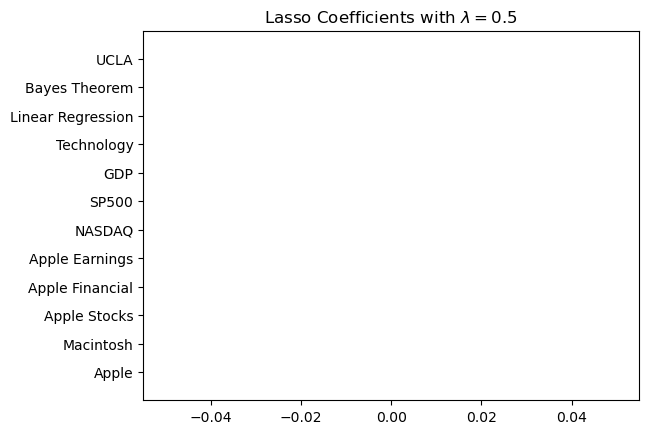

In [21]:
plt.barh(df.columns, lasso_result.coef_)
plt.title('Lasso Coefficients with $\lambda = 0.5$')
plt.plot()

Using a $\lambda = 0.5$ all the coefficients are zero. Meaning that we are penalizing the model excessively.

# 5.) Run a for loop looking at 10 different Lambdas and plot the coefficient magnitude for each.

In [22]:
l_sim = np.linspace(0, 0.5, 1_000)
coef = np.nan * np.ones((len(l_sim), X_scaled.shape[1]))
for i, l in enumerate(l_sim):
    lasso = Lasso(alpha=l)
    lasso_result = lasso.fit(X_scaled,y)
    coef[i,:] = lasso_result.coef_

Text(0, 0.5, 'Coefficient')

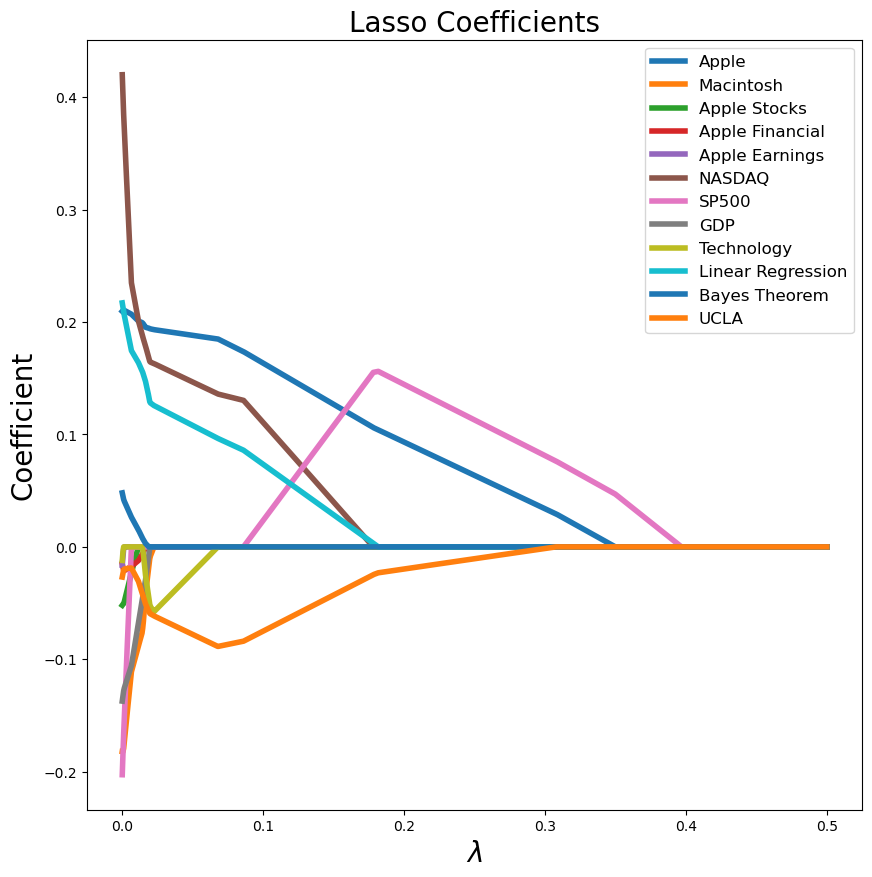

In [23]:
plt.figure(figsize=(10,10))
for i in range(coef.shape[1]):
    plt.plot(
        l_sim, coef[:,i],
        label=df.columns[i],
        linewidth=4
    )
plt.legend(
    df.columns,
    fontsize=12,
)
plt.title('Lasso Coefficients', fontsize=20)
plt.xlabel('$\lambda$', fontsize=20)
plt.ylabel('Coefficient', fontsize=20)

# 6.) Run a cross validation. What is your ideal lambda?

In [24]:
from sklearn.linear_model import LassoCV

In [25]:
modCV = LassoCV(cv=5).fit(X_scaled,y)

In [26]:
opt_l = modCV.alpha_
opt_coef = modCV.coef_
print(f'Optimal lambda: {np.round(opt_l, 5)}')

Optimal lambda: 0.0037


[]

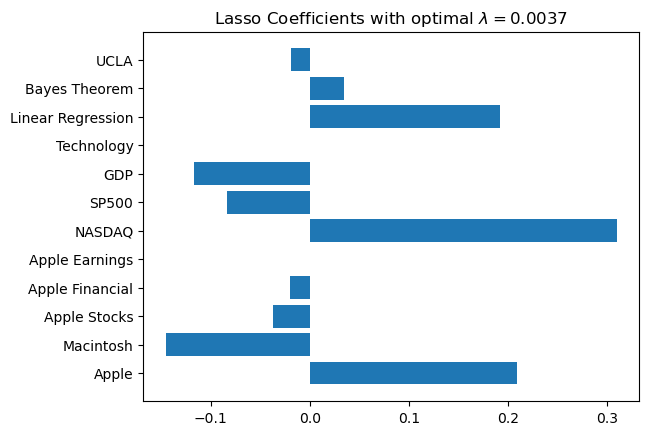

In [27]:
plt.barh(df.columns, opt_coef)
plt.title(f'Lasso Coefficients with optimal $\lambda = {np.round(opt_l, 5)}$')
plt.plot()